In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot  as plt
from sklearn import tree
from collections import Counter
import sklearn.model_selection
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, KFold, cross_validate, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import confusion_matrix, precision_recall_curve, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from numpy import mean, std
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Contents:

* Models based on X_personal data
    * Decision tree
    * Logistic regression
    * SVM
    * RBF SVM
    * Logistic regression with poly features


* Implementation of all features (w1)
    * Correlation between features
    * Decision tree
    * Logistic regression
    * SVM
    * RBF SVM
    
    
* Poly personal + political 
    * Decision tree
    * Logistic regression
    * SVM
    * RBF SVM
    
    
* Poly important + others 
    * Decision tree
    * Logistic regression
    * SVM
    * RBF SVM
    
    
* Features interaction (Bundesland and gender)
    * Decision tree
    * Logistic regression
    * SVM
    * RBF SVM
    

* Final table of results

# models based on X_personal data

train-test split, **20% of samples are test**

proportions between 1 and 0 class are the same in both test and train sets

In [2]:
df = pd.read_csv('../data/data_multi_personal_online.csv')

In [3]:
y = df['panelpat']
X = df.drop(['panelpat'], axis=1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## DECISION TREE
initial parameters, 10-fold validation, the randomness of the estimator is 0 (random_state=0)

In [5]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}
kfold = KFold(n_splits=10)
clf = DecisionTreeClassifier(random_state=0)
results = cross_validate(estimator=clf,
                                    X=X_train,
                                    y=y_train,
                                    cv=kfold,
                                    scoring=scoring)
results = pd.DataFrame(results)

In [6]:
all_precision_plot = []
all_recall_plot = []
all_test_f1_score_plot = []
all_accuracy_plot = []
all_specificity_plot = []

def add_to_final_table(X_test, y_test):
    accuracy = clf_fit.score(X_test, y_test)
    y_pred = clf_fit.predict(X_test)
    conf = confusion_matrix(y_test, y_pred)

    test_f1_score = f1_score(y_test, y_pred)
    tn, fp, fn, tp = conf.ravel()
    tnfp = tn+fp
    if tnfp == 0:
        specificity = 1
    else:
        specificity = tn / (tn+fp)
    all_specificity_plot.append(specificity)
    all_precision_plot.append(precision_score(y_test, y_pred))
    all_recall_plot.append(recall_score(y_test, y_pred))
    all_test_f1_score_plot.append(test_f1_score)
    all_accuracy_plot.append(accuracy)

In [7]:
precision_plot = []
recall_plot = []
test_f1_score_plot = []
accuracy_plot = []

accuracy_tree = mean(results['test_accuracy'])
precision_tree = mean(results['test_precision'])
recall_tree = mean(results['test_recall'])
test_f1_score_tree = mean(results['test_f1_score'])

precision_plot.append(precision_tree)
recall_plot.append(recall_tree)
test_f1_score_plot.append(test_f1_score_tree)
accuracy_plot.append(accuracy_tree)

accuracy_std = std(results['test_accuracy'])
precision_std = std(results['test_precision'])
recall_std = std(results['test_recall'])
test_f1_score_std = std(results['test_f1_score'])

print('accuracy', round(accuracy_tree, 3))
print('precision', round(precision_tree, 3))
print('recall', round(recall_tree, 3))
print('test_f1_score', round(test_f1_score_tree, 3))
print(' ')
print('accuracy_std', round(accuracy_std, 3))
print('precision_std', round(precision_std, 3))
print('recall_std', round(recall_std, 3))
print('test_f1_score_std', round(test_f1_score_std, 3))

accuracy 0.563
precision 0.587
recall 0.562
test_f1_score 0.572
 
accuracy_std 0.058
precision_std 0.067
recall_std 0.059
test_f1_score_std 0.057


trying to tune parameters using CV: 
* max_depth = 4 (keeping tree structure simple)
* min_samples_leaf = [100, 400]
* refit = False because it should be set like that when mulpiple metrics for evaluation are used (Refit an estimator using the best found parameters on the whole dataset)

In [8]:
min_samples_leaf_list = list(range(100, 400))

In [9]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), 
                  param_grid={'max_depth': [4], 
                              'min_samples_leaf': min_samples_leaf_list}, 
                  cv=5, scoring=scoring, refit=False)
gs.fit(X_train, y_train)
results = pd.DataFrame(gs.cv_results_)

plotting the results

In [10]:
test_f1_score_tree_train = results['mean_test_f1_score']
precision_tree_train = results['mean_test_precision']
recall_tree_train = results['mean_test_recall']
accuracy_tree_train = results['mean_test_accuracy']

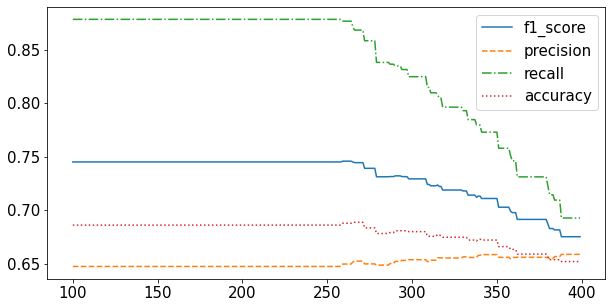

In [11]:
font = {'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
plt.figure(figsize=(10, 5))
plt.plot(min_samples_leaf_list, test_f1_score_tree_train, label="f1_score", linestyle="-")
plt.plot(min_samples_leaf_list, precision_tree_train, label="precision", linestyle="--")
plt.plot(min_samples_leaf_list, recall_tree_train, label="recall", linestyle="-.")
plt.plot(min_samples_leaf_list, accuracy_tree_train, label="accuracy", linestyle=":")
plt.legend()
plt.show()

according plot the good number for min_samples_leaf is around 160

now check the model on test set

In [12]:
clf = DecisionTreeClassifier(min_samples_leaf=160, max_depth=4)
clf_fit = clf.fit(X_train, y_train)
accuracy = clf_fit.score(X_test, y_test)
y_pred = clf_fit.predict(X_test)
conf = confusion_matrix(y_test, y_pred)

test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

print('Precision:', round(precision_score(y_test, y_pred), 3))
print('Recall:', round(recall_score(y_test, y_pred), 3))
print('f1_score:', round(test_f1_score, 3))
print('Accuracy: %.3f' % accuracy)
add_to_final_table(X_test, y_test)

Precision: 0.644
Recall: 0.88
f1_score: 0.744
Accuracy: 0.683


In [13]:
# assigning names for columns for plotting decision tree
X.feature_names = X.columns
y.feature_names = ['drop']

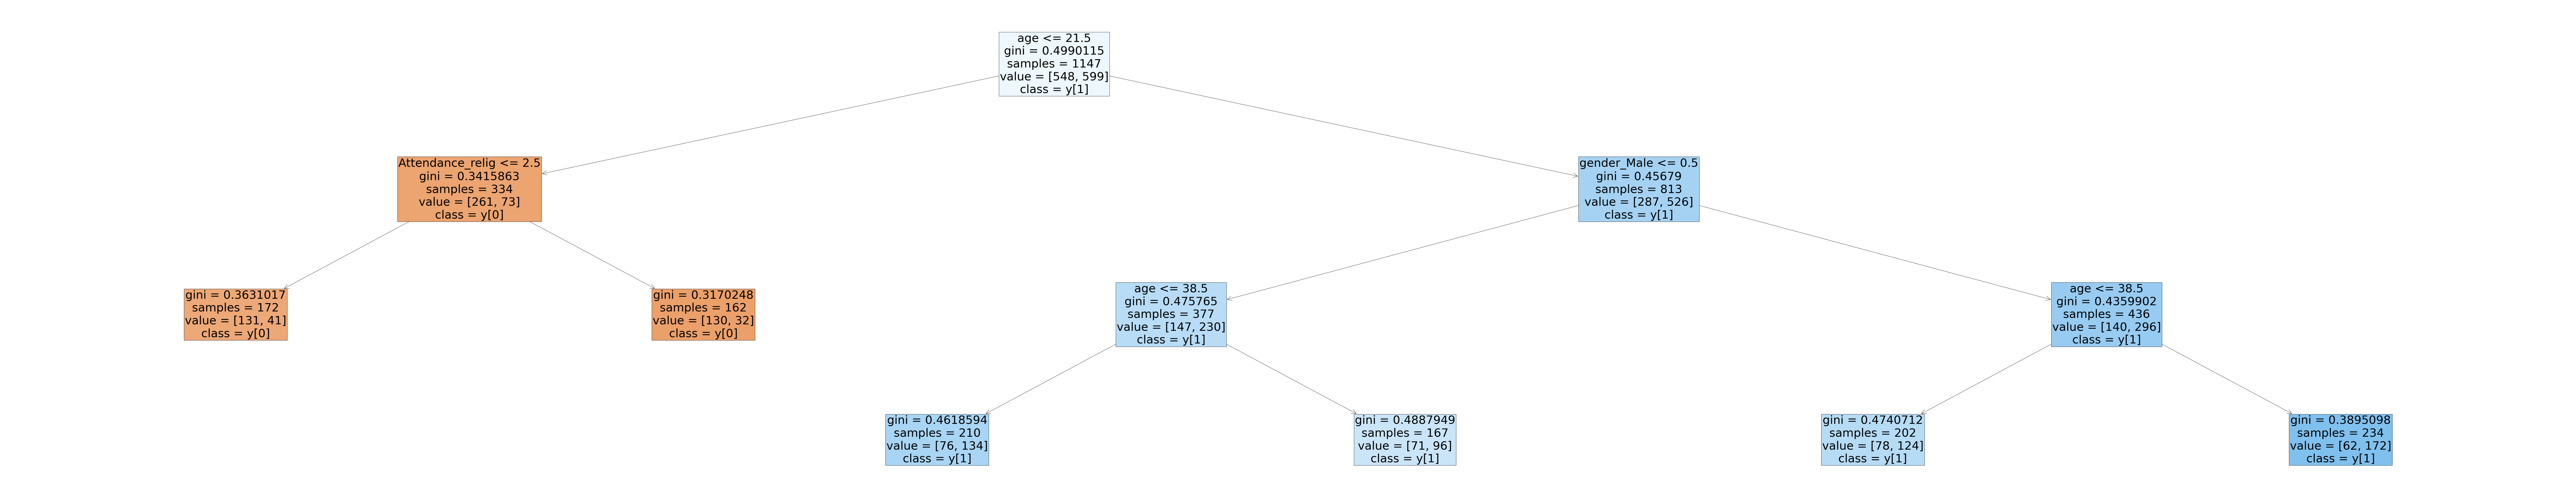

In [14]:
fig = plt.figure(figsize=(200, 40))

_ = tree.plot_tree(clf_fit, filled=True, feature_names=X.feature_names, class_names=True, fontsize=50, precision=7)
plt.show()

since there are both ordinal and ohe features I scale it for future analysis

In [15]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size=0.2, stratify=y)

## SVM 
LinearSVC implementation, C=0.01

In [16]:
clf = LinearSVC(C=0.01, max_iter=10000)
clf_fit = clf.fit(X_train, y_train)

accuracy = clf_fit.score(X_test, y_test)
y_pred = clf_fit.predict(X_test)
conf = confusion_matrix(y_test, y_pred)

test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

print('Precision:', round(precision_score(y_test, y_pred), 3))
print('Recall:', round(recall_score(y_test, y_pred), 3))
print('f1_score:', round(test_f1_score, 3))
print('Accuracy: %.3f' % accuracy)
add_to_final_table(X_test, y_test)

Precision: 0.597
Recall: 0.76
f1_score: 0.669
Accuracy: 0.606


below I made LinearSVC with different values of regularization parameter C (from 0.00001 to 10)

In [17]:
precision_list = []
f1_score_list = []
recall_list = []
accuracy_list = []
C_list = []
j = 0.00001
while j < 0.15:
    
    clf = LinearSVC(C=j, max_iter=10000000)
    clf_fit = clf.fit(X_train, y_train)

    y_pred = clf_fit.predict(X_test)
    precision_result = precision_score(y_test, y_pred)
    f1_score_result = f1_score(y_test, y_pred)
    recall_result = recall_score(y_test, y_pred)
    accuracy_result = clf_fit.score(X_test, y_test)

    precision_list.append(precision_result)
    f1_score_list.append(f1_score_result)
    recall_list.append(recall_result)
    accuracy_list.append(accuracy_result)
    
    j *= 2
    C_list.append(j)

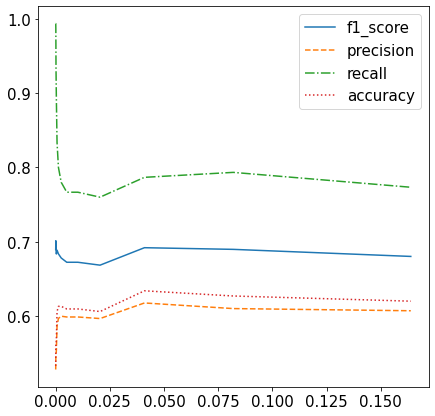

In [18]:
font = {'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
plt.figure(figsize=(7, 7))
plt.plot(C_list, f1_score_list, label="f1_score", linestyle="-")
plt.plot(C_list, precision_list, label="precision", linestyle="--")
plt.plot(C_list, recall_list, label="recall", linestyle="-.")
plt.plot(C_list, accuracy_list, label="accuracy", linestyle=":")
plt.legend()
plt.show()

obtained results demonstrate that there is no huge difference with C parameter, 0.05 seems to be fine value in general


In [19]:
clf = LinearSVC(C=0.05, max_iter=100000)
clf_fit = clf.fit(X_train, y_train)
accuracy = clf_fit.score(X_test, y_test)
y_pred = clf_fit.predict(X_test)
conf = confusion_matrix(y_test, y_pred)
test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

print('Precision:', round(precision_score(y_test, y_pred), 3))
print('Recall:', round(recall_score(y_test, y_pred), 3))
print('f1_score:', round(test_f1_score, 3))
print('Accuracy: %.3f' % accuracy)
add_to_final_table(X_test, y_test)

Precision: 0.605
Recall: 0.787
f1_score: 0.684
Accuracy: 0.620


## RBF SVM

In [20]:
clf = SVC()
clf_fit = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
conf = confusion_matrix(y_test, y_pred)
accuracy = clf_fit.score(X_test, y_test)

test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

print('Precision:', round(precision_score(y_test, y_pred), 3))
print('Recall:', round(recall_score(y_test, y_pred), 3))
print('f1_score:', round(test_f1_score, 3))
print('Accuracy: %.3f' % accuracy)
add_to_final_table(X_test, y_test)

Precision: 0.601
Recall: 0.813
f1_score: 0.691
Accuracy: 0.620


## LOGISTIC REGRESSION

In [21]:
clf = LogisticRegression(max_iter=10000).fit(X_train, y_train)
y_pred = clf.predict(X_test)
conf = confusion_matrix(y_test, y_pred)
accuracy = clf.score(X_test, y_test)

test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

print('Precision:', round(precision_score(y_test, y_pred), 3))
print('Recall:', round(recall_score(y_test, y_pred), 3))
print('f1_score:', round(test_f1_score, 3))
print('Accuracy: %.3f' % accuracy)
add_to_final_table(X_test, y_test)

Precision: 0.615
Recall: 0.767
f1_score: 0.682
Accuracy: 0.627


In [22]:
feature_coef = pd.DataFrame(clf.coef_)
feature_coef.columns = X.columns
feature_coef.index = ['coef']
feature_coef = feature_coef.T
feature_coef = feature_coef.sort_values(by=['coef'], ascending=False)

In [23]:
#feature_coef

## LOGISTIC REGRESSION WITH POLY FEATURES

In [24]:
poly = PolynomialFeatures(interaction_only=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
clf = LogisticRegression(max_iter=100000)
clf_fit = clf.fit(X_train_poly, y_train)

y_pred = clf.predict(X_test_poly)

accuracy = clf_fit.score(X_test_poly, y_test)

test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

print('Precision:', round(precision_score(y_test, y_pred), 3))
print('Recall:', round(recall_score(y_test, y_pred), 3))
print('f1_score:', round(test_f1_score, 3))
print('Accuracy: %.3f' % accuracy)
add_to_final_table(X_test_poly, y_test)

Precision: 0.594
Recall: 0.693
f1_score: 0.64
Accuracy: 0.592


In [25]:
def table_of_results(list_of_models, precision_plot, recall_plot, test_f1_score_plot, accuracy_plot):
    results_plot = pd.DataFrame(zip(precision_plot, recall_plot,
                                    test_f1_score_plot, accuracy_plot)).T
    results_plot.columns = list_of_models
    results_plot.index = ['precision, %',
                          'recall, %',
                          'f1_score, %',
                          'accuracy, %']
    results_plot = results_plot.round(3)
    results_plot = results_plot.mul(100)
       
    return results_plot.T

In [26]:
list_of_models = ['DECISION TREE - default', 'DECISION TREE - more leaves', 
                  'LINEAR SVM - default', 'LINEAR SVM - C=0.05',
                  'RBF SVM',
                  'LOGISTIC REGRESSION',
                  'LOGISTIC REGRESSION WITH POLY FEATURES']

In [27]:
def print_results(results_plot):
    cm = sns.light_palette("green", as_cmap=True)
    return results_plot.T.style.background_gradient(cmap=cm)

def plot_results(results_plot):
    font = {'weight' : 'normal',
            'size'   : 8}
    plt.rc('font', **font)
    plt.figure(figsize=(10, 7))
    results_plot.T.plot.line()

In [28]:
results_plot = table_of_results(list_of_models, precision_plot, recall_plot, test_f1_score_plot, accuracy_plot)

*PERSONAL FEATURES*

In [29]:
results_plot

,"precision, %","recall, %","f1_score, %","accuracy, %"
DECISION TREE - default,58.7,56.2,57.2,56.3
DECISION TREE - more leaves,64.4,88.0,74.4,68.3
LINEAR SVM - default,59.7,76.0,66.9,60.6
LINEAR SVM - C=0.05,60.5,78.7,68.4,62.0
RBF SVM,60.1,81.3,69.1,62.0
LOGISTIC REGRESSION,61.5,76.7,68.2,62.7
LOGISTIC REGRESSION WITH POLY FEATURES,59.4,69.3,64.0,59.2


<Figure size 720x504 with 0 Axes>

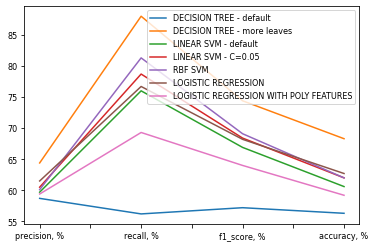

In [30]:
plot_results(results_plot)

so the most important features from here are: 
* age
* income
* occupation
* country of birth

# IMPLEMENTATION OF ALL FEATURES from wave 1

In [31]:
df = pd.read_csv('../data/data_multi_political_online.csv')
#df = df.filter(regex='(w1)')
df = df.drop(['panelpat'], axis=1)

concatenating politics related features with personal ones, dropping features from waves 2 and 3

In [32]:
X = pd.concat([X, df], axis=1)
#X = X[X.columns.drop(list(X.filter(regex='w3')))]
#X = X[X.columns.drop(list(X.filter(regex='w2')))]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40, test_size=0.2, stratify=y)

#### correlation between features 
showing only features with corr > 0.65 (and <1 because that would be feature itself on diagonal matrix)

In [34]:
corr_df = pd.concat([X, y], axis=1)
corr_mat = corr_df.corr()
sorted_mat = corr_mat.unstack().sort_values()
strong_pairs = pd.DataFrame(sorted_mat.loc[(sorted_mat > 0.65) & (sorted_mat < 1)])
strong_pairs.columns = ['correlation']
strong_pairs = strong_pairs.drop_duplicates(['correlation'])

In [35]:
cm = sns.light_palette("red", as_cmap=True)
strong_pairs.style.background_gradient(cmap=cm)

,,correlation
PARTY CHOICE: PROSPECTIVE -w1_q24_List Sebastian Kurz - the New People's Party,DIRECT ELECTION OF CHANCELLOR -w1_q26_Sebastian Kurz,0.650115
VOTE CHOICE NATIONAL ELECTION 2013: -w1_q9_was not eligible to vote,FIRST-TIME VOTER -w1_ew,0.655925
w1_occupation_area_employee,w1_occupation_employed,0.680973
OPINION: IMMIGRANTS ENRICH AUSTRIAN CULTURE -w1_q10x2,OPINION: IMMIGRANTS ARE GOOD FOR THE AUSTRIAN ECONOMY -w1_q10x3,0.700440
PARTY CHOICE: PROSPECTIVE -w1_q24_FPOE,DIRECT ELECTION OF CHANCELLOR -w1_q26_Heinz-Christian Strache,0.701597
PTV: LIST SEBASTIAN KURZ - THE NEW PEOPLES PARTY -w1_q22x2,LIKE-DISLIKE SEBASTIAN KURZ: -w1_q18x2,0.712480
LIKE-DISLIKE ULRIKE LUNACEK: -w1_q18x4,LIKE-DISLIKE MATTHIAS STROLZ: -w1_q18x5,0.736127
LEFT-RIGHT PLACEMENT NEOS: -w1_q11x5,LEFT-RIGHT PLACEMENT TEAM STRONACH: -w1_q11x6,0.739751
PTV: FPOE -w1_q22x3,LIKE-DISLIKE HEINZ-CHRISTIAN STRACHE: -w1_q18x3,0.803560
YOUNG VOTER (YOUNGER THAN 21) -w1_jw_no,voting_age_awareness -w1_q20_14,0.832828


correlated: 
* age and occupation/eligibility to vote/vote choice
* politics and their parties

In [36]:
#correlation of all features
#cm = sns.light_palette("green", as_cmap=True)
#corr_mat.T.style.background_gradient(cmap=cm)

## DECISION TREE
default parameters, 10-fold cross validation

In [37]:
kfold = KFold(n_splits=10)
clf = DecisionTreeClassifier(random_state=0)
results = cross_validate(estimator=clf,
                                    X=X_train,
                                    y=y_train,
                                    cv=kfold,
                                    scoring=scoring)
results = pd.DataFrame(results)

In [38]:
precision_plot = []
recall_plot = []
test_f1_score_plot = []
accuracy_plot = []

accuracy_tree = mean(results['test_accuracy'])
precision_tree = mean(results['test_precision'])
recall_tree = mean(results['test_recall'])
test_f1_score_tree = mean(results['test_f1_score'])

precision_plot.append(precision_tree)
recall_plot.append(recall_tree)
test_f1_score_plot.append(test_f1_score_tree)
accuracy_plot.append(accuracy_tree)

accuracy_std = std(results['test_accuracy'])
precision_std = std(results['test_precision'])
recall_std = std(results['test_recall'])
test_f1_score_std = std(results['test_f1_score'])

print('accuracy', round(accuracy_tree, 3))
print('precision', round(precision_tree, 3))
print('recall', round(recall_tree, 3))
print('test_f1_score', round(test_f1_score_tree, 3))
print(' ')
print('accuracy_std', round(accuracy_std, 3))
print('precision_std', round(precision_std, 3))
print('recall_std', round(recall_std, 3))
print('test_f1_score_std', round(test_f1_score_std, 3))

accuracy 0.628
precision 0.648
recall 0.645
test_f1_score 0.644
 
accuracy_std 0.05
precision_std 0.072
recall_std 0.032
test_f1_score_std 0.042


trying to tune parameters using CV: 
* max_depth = 4 (keeping tree structure simple)
* min_samples_leaf = [100, 400]
* refit = False because it should be set like that when mulpiple metrics for evaluation are used (Refit an estimator using the best found parameters on the whole dataset)

In [39]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), 
                  param_grid={'max_depth': [4], 
                              'min_samples_leaf': min_samples_leaf_list}, 
                  cv=5, scoring=scoring, refit=False)
gs.fit(X_train, y_train)
results = pd.DataFrame(gs.cv_results_)
test_f1_score_tree_train = results['mean_test_f1_score']
precision_tree_train = results['mean_test_precision']
recall_tree_train = results['mean_test_recall']
accuracy_tree_train = results['mean_test_accuracy']

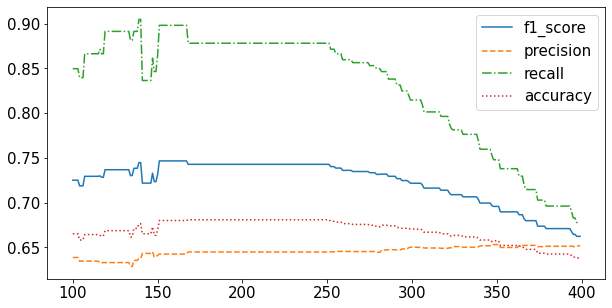

In [40]:
font = {'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
plt.figure(figsize=(10, 5))
plt.plot(min_samples_leaf_list, test_f1_score_tree_train, label="f1_score", linestyle="-")
plt.plot(min_samples_leaf_list, precision_tree_train, label="precision", linestyle="--")
plt.plot(min_samples_leaf_list, recall_tree_train, label="recall", linestyle="-.")
plt.plot(min_samples_leaf_list, accuracy_tree_train, label="accuracy", linestyle=":")
plt.legend()
plt.show()

checking model on test set, min_samples_leaf = 100

In [41]:
def train_scores(X_train, y_train):
    y_pred = clf_fit.predict(X_train)
    
    print('Precision_train:', round(precision_score(y_train, y_pred), 3))
    print('Recall_train:', round(recall_score(y_train, y_pred), 3))
    test_f1_score = f1_score(y_train, y_pred)
    accuracy = clf_fit.score(X_train, y_train)
    print('f1_score_train:', round(test_f1_score, 3))
    print('Accuracy_train: %.3f' % accuracy)
    
def test_scores(X_test, y_test):
    y_pred = clf_fit.predict(X_test)
    accuracy = clf_fit.score(X_test, y_test)
    test_f1_score = f1_score(y_test, y_pred)

    print('Precision:', round(precision_score(y_test, y_pred), 3))
    print('Recall:', round(recall_score(y_test, y_pred), 3))
    print('f1_score:', round(test_f1_score, 3))
    print('Accuracy: %.3f' % accuracy)
    print('_____________')

In [42]:
clf = DecisionTreeClassifier(min_samples_leaf=100, max_depth=4)
clf_fit = clf.fit(X_train, y_train)
accuracy = clf_fit.score(X_test, y_test)
y_pred = clf_fit.predict(X_test)
conf = confusion_matrix(y_test, y_pred)

test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

test_scores(X_test, y_test)
train_scores(X_train, y_train)
add_to_final_table(X_test, y_test)

Precision: 0.654
Recall: 0.82
f1_score: 0.728
Accuracy: 0.679
_____________
Precision_train: 0.655
Recall_train: 0.851
f1_score_train: 0.74
Accuracy_train: 0.688


In [43]:
# assigning names for columns for plotting decision tree
X.feature_names = X.columns
y.feature_names = ['drop']

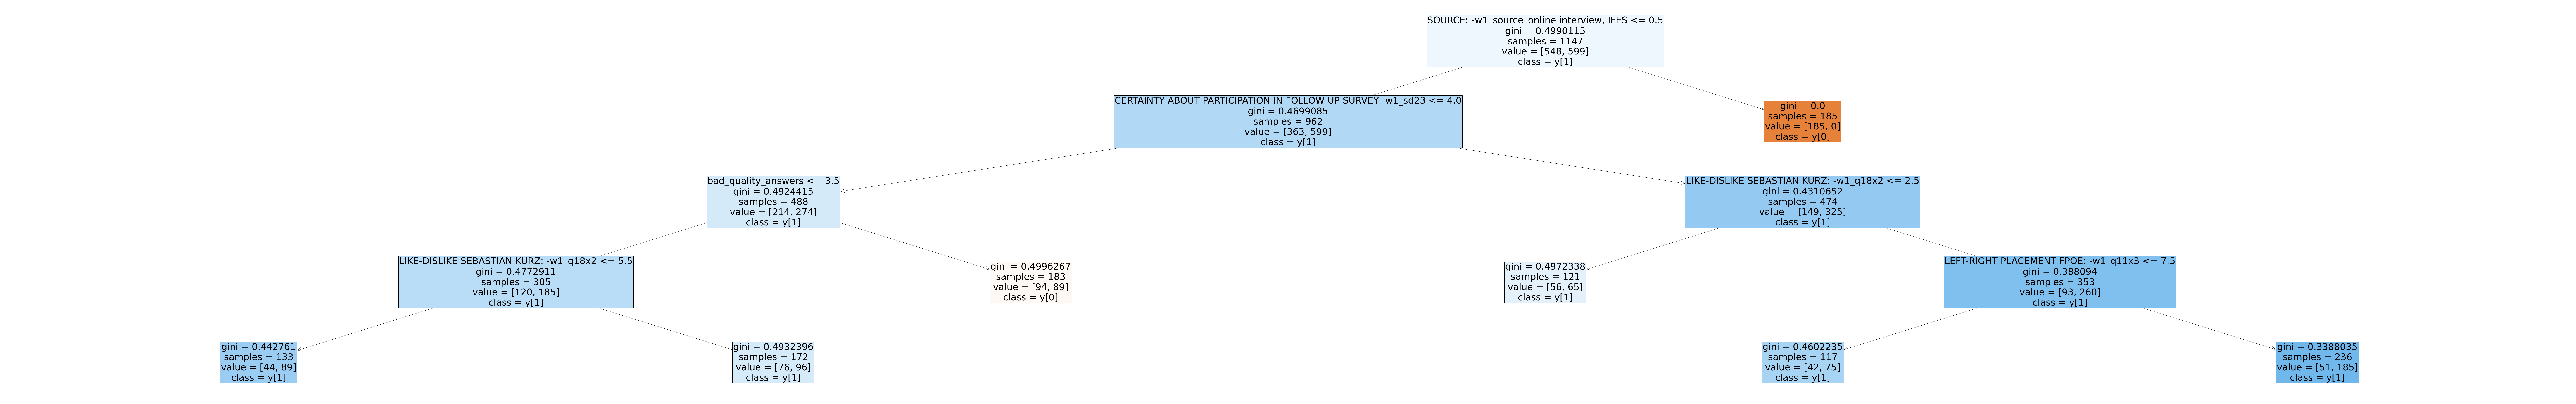

In [44]:
fig = plt.figure(figsize=(250, 40))

_ = tree.plot_tree(clf_fit, filled=True, feature_names=X.feature_names, class_names=True, fontsize=50, precision=7)
plt.show()
fig.savefig('pol_tree_multi_online.pdf')

In [45]:
X_train.shape

(1147, 175)

the most important features are:
    * Age group based on year of birth -sd2x2
    * attention (check question)
    * INTERVIEW DURATION IN SECONDS -w2_intdur 

scaling features for other models

In [46]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size=0.2, stratify=y)

In [47]:
X_train.columns = X.columns

## LOGISTIC REGRESSION
default parameters

In [48]:
clf_fit = LogisticRegression(max_iter=10000).fit(X_train, y_train)
y_pred = clf_fit.predict(X_test)
conf = confusion_matrix(y_test, y_pred)
accuracy = clf_fit.score(X_test, y_test)

test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

test_scores(X_test, y_test)
train_scores(X_train, y_train)
add_to_final_table(X_test, y_test)

Precision: 0.626
Recall: 0.727
f1_score: 0.673
Accuracy: 0.631
_____________
Precision_train: 0.724
Recall_train: 0.873
f1_score_train: 0.792
Accuracy_train: 0.760


In [49]:
feature_coef = pd.DataFrame(clf_fit.coef_)

In [50]:
feature_coef.columns = X.columns
feature_coef.index = ['coef']
feature_coef = feature_coef.T

In [51]:
feature_coef = feature_coef.sort_values(by=['coef'], ascending=False)

In [52]:
feature_coef_abs = abs(feature_coef['coef'])
feature_coef_abs = feature_coef_abs.sort_values(ascending=False)
feature_coef_abs_20 = feature_coef_abs[:20]

In [53]:
most_important_features = feature_coef_abs_20.index

In [54]:
most_important_features_coeffs = feature_coef.loc[most_important_features]


showing 20 features with largest coefficients

In [55]:
most_important_features_coeffs

,coef
"SOURCE: -w1_source_online interview, IFES",-2.940391
"SOURCE: -w1_source_online interview, Marketagent",1.703604
w1_occupation_area_self-employed with employees,-1.277866
"SOURCE: -w1_source_online interview, recruted offline",1.239857
UNION MEMBERSHIP -w1_sd17_don't know,-1.205394
Country_of_birth_other,-1.014105
LIKE-DISLIKE HEINZ-CHRISTIAN STRACHE: -w1_q18x3,0.923428
"OPINION: PROTECT ENVIRONMENT, EVEN IF LIFE BECOMES MORE EXPENSIVE -w1_q17x4",-0.907218
CERTAINTY ABOUT PARTICIPATION IN FOLLOW UP SURVEY -w1_sd23,0.881064
religion_Christian-orthodox church,-0.826530


## SVM 
default parameters

In [56]:
clf = LinearSVC(C=0.01, max_iter=10000)
clf_fit = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
conf = confusion_matrix(y_test, y_pred)

accuracy = clf_fit.score(X_test, y_test)
test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

test_scores(X_test, y_test)
train_scores(X_train, y_train)
add_to_final_table(X_test, y_test)

Precision: 0.648
Recall: 0.847
f1_score: 0.734
Accuracy: 0.679
_____________
Precision_train: 0.677
Recall_train: 0.915
f1_score_train: 0.778
Accuracy_train: 0.727


other regularization parameter (C) values

In [57]:
precision_list = []
f1_score_list = []
recall_list = []
accuracy_list = []
C_list = []
j = 0.00001
while j < 0.15:
    
    clf = LinearSVC(C=j, max_iter=10000000)
    clf_fit = clf.fit(X_train, y_train)

    y_pred = clf_fit.predict(X_test)
    precision_result = precision_score(y_test, y_pred)
    f1_score_result = f1_score(y_test, y_pred)
    recall_result = recall_score(y_test, y_pred)
    accuracy_result = clf_fit.score(X_test, y_test)

    precision_list.append(precision_result)
    f1_score_list.append(f1_score_result)
    recall_list.append(recall_result)
    accuracy_list.append(accuracy_result)
    
    j *= 2
    C_list.append(j)

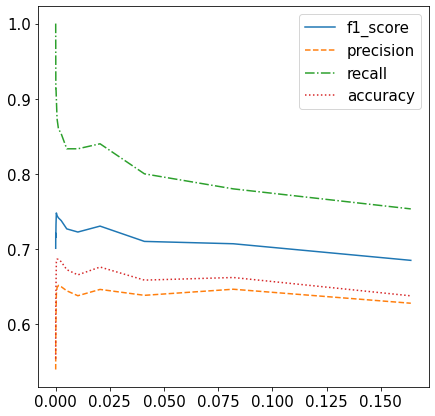

In [58]:
font = {'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
plt.figure(figsize=(7, 7))
plt.plot(C_list, f1_score_list, label="f1_score", linestyle="-")
plt.plot(C_list, precision_list, label="precision", linestyle="--")
plt.plot(C_list, recall_list, label="recall", linestyle="-.")
plt.plot(C_list, accuracy_list, label="accuracy", linestyle=":")
plt.legend()
plt.show()

here all the values of C do not really make a lot of difference

## RBF SVM 
default parameters

In [59]:
clf = SVC()
clf_fit = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
conf = confusion_matrix(y_test, y_pred)
accuracy = clf_fit.score(X_test, y_test)
test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

test_scores(X_test, y_test)
train_scores(X_train, y_train)
add_to_final_table(X_test, y_test)

Precision: 0.659
Recall: 0.927
f1_score: 0.77
Accuracy: 0.711
_____________
Precision_train: 0.686
Recall_train: 0.99
f1_score_train: 0.811
Accuracy_train: 0.759


playing with other parameters 

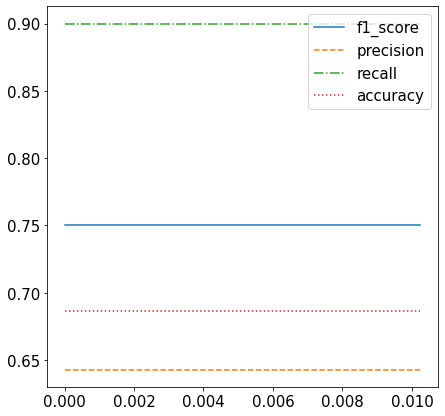

In [60]:
precision_list = []
f1_score_list = []
recall_list = []
accuracy_list = []
C_list = []
j = 0.00001
while j < 0.01:
    
    clf = SVC(kernel='sigmoid')
    clf_fit = clf.fit(X_train, y_train)

    y_pred = clf_fit.predict(X_test)
    precision_result = precision_score(y_test, y_pred)
    f1_score_result = f1_score(y_test, y_pred)
    recall_result = recall_score(y_test, y_pred)
    accuracy_result = clf_fit.score(X_test, y_test)

    precision_list.append(precision_result)
    f1_score_list.append(f1_score_result)
    recall_list.append(recall_result)
    accuracy_list.append(accuracy_result)
    
    j *= 2
    C_list.append(j)
    
font = {'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
plt.figure(figsize=(7, 7))
plt.plot(C_list, f1_score_list, label="f1_score", linestyle="-")
plt.plot(C_list, precision_list, label="precision", linestyle="--")
plt.plot(C_list, recall_list, label="recall", linestyle="-.")
plt.plot(C_list, accuracy_list, label="accuracy", linestyle=":")
plt.legend()
plt.show()

default features look fine because even with the smallest interval of C results do not change the result a lot (I have tried different intervals and kernels)

In [61]:
list_of_models = ['DECISION TREE - default',
                  'DECISION TREE - more leaves',
                  'LOGISTIC REGRESSION - default',
                  'LINEAR SVM - default',
                  'RBF SVM'] 

In [62]:
results_plot = table_of_results(list_of_models, precision_plot, recall_plot, test_f1_score_plot, accuracy_plot)

all features from wave 1

In [63]:
results_plot

,"precision, %","recall, %","f1_score, %","accuracy, %"
DECISION TREE - default,64.8,64.5,64.4,62.8
DECISION TREE - more leaves,65.4,82.0,72.8,67.9
LOGISTIC REGRESSION - default,62.6,72.7,67.3,63.1
LINEAR SVM - default,64.8,84.7,73.4,67.9
RBF SVM,65.9,92.7,77.0,71.1


<Figure size 720x504 with 0 Axes>

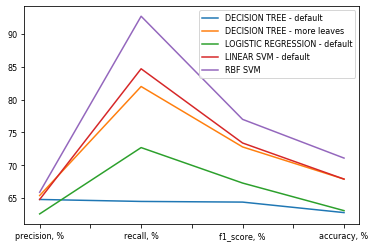

In [64]:
plot_results(results_plot)

# *THE MOST IMPORTANT FEATURES:*

the most important features are related to **age, source, certainty about participation in follow up survey, occupation, voting_age_awareness**:
* SOURCE: -w1_source_online interview, IFES
* SOURCE: -w1_source_online interview, Marketagent
* CERTAINTY ABOUT PARTICIPATION IN FOLLOW UP SURVEY -w1_sd23
* SOURCE: -w1_source_online interview, recruted offline
* Country_of_birth_other
* w1_occupation_area_farmer
* religion_Christian-orthodox church
* UNION MEMBERSHIP -w1_sd17_don't know
* PARTY R. FEELS CLOSER TO: -w1_q15_KPOE
* w1_occupation_weiss nicht
* DEGREE OF CLOSENESS TO PARTY -w1_q16
* PARTY R. FEELS CLOSER TO: -w1_q15_CPOE
* ECON. SITUATION AUSTRIA: RETROSPECTIVE (PAST 12 MONTHS) -w1_q3
* w1_occupation_area_self-employed with employees
* w1_occupation_military/civilian service, voluntary social year
* OPINION: PROTECT ENVIRONMENT, EVEN IF LIFE BECOMES MORE EXPENSIVE -w1_q17x4
* VOTE CHOICE NATIONAL ELECTION 2013: -w1_q9_BZOE
* Attendance_relig
* VOTE CHOICE NATIONAL ELECTION 2013: -w1_q9_CPOE
* PTV: LIST SEBASTIAN KURZ - THE NEW PEOPLES PARTY -w1_q22x2

# POLY PERSONAL + POLITICAL
all features included, personal ones are polynomial with degree 2 + political ones

In [65]:
df = pd.read_csv('../data/data_multi_personal_online.csv')
y = df['panelpat']
X_personal = df.drop(['panelpat'], axis=1)

In [66]:
poly = PolynomialFeatures(interaction_only=True)
X_personal_poly = pd.DataFrame(poly.fit_transform(X_personal))

In [67]:
X_political = pd.read_csv('../data/data_multi_political_online.csv')
#X_political = X_political.drop(['panelpat'], axis=1)
X_political = X_political.filter(regex='(w1)')


In [68]:
X = pd.concat([X_personal_poly, X_political], axis=1)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## DECISION TREE
default parameters

In [70]:
kfold = KFold(n_splits=5)
clf = DecisionTreeClassifier(random_state=0)
results = cross_validate(estimator=clf,
                                    X=X_train,
                                    y=y_train,
                                    cv=kfold,
                                    scoring=scoring)
results = pd.DataFrame(results)

In [71]:
precision_plot = []
recall_plot = []
test_f1_score_plot = []
accuracy_plot = []

accuracy_tree = mean(results['test_accuracy'])
precision_tree = mean(results['test_precision'])
recall_tree = mean(results['test_recall'])
test_f1_score_tree = mean(results['test_f1_score'])

precision_plot.append(precision_tree)
recall_plot.append(recall_tree)
test_f1_score_plot.append(test_f1_score_tree)
accuracy_plot.append(accuracy_tree)

accuracy_std = std(results['test_accuracy'])
precision_std = std(results['test_precision'])
recall_std = std(results['test_recall'])
test_f1_score_std = std(results['test_f1_score'])

print('accuracy', round(accuracy_tree, 3))
print('precision', round(precision_tree, 3))
print('recall', round(recall_tree, 3))
print('test_f1_score', round(test_f1_score_tree, 3))
print(' ')
print('accuracy_std', round(accuracy_std, 3))
print('precision_std', round(precision_std, 3))
print('recall_std', round(recall_std, 3))
print('test_f1_score_std', round(test_f1_score_std, 3))

accuracy 0.595
precision 0.618
recall 0.591
test_f1_score 0.603
 
accuracy_std 0.03
precision_std 0.048
recall_std 0.038
test_f1_score_std 0.034


tuning number of leaves

In [72]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), 
                  param_grid={'max_depth': [4], 
                              'min_samples_leaf': min_samples_leaf_list}, 
                  cv=5, scoring=scoring, refit=False)
gs.fit(X_train, y_train)
results = pd.DataFrame(gs.cv_results_)
test_f1_score_tree_train = results['mean_test_f1_score']
precision_tree_train = results['mean_test_precision']
recall_tree_train = results['mean_test_recall']
accuracy_tree_train = results['mean_test_accuracy']

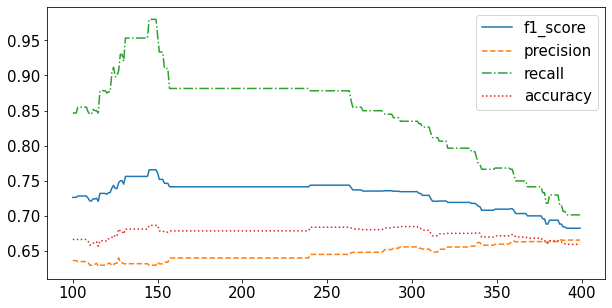

In [73]:
font = {'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
plt.figure(figsize=(10, 5))
plt.plot(min_samples_leaf_list, test_f1_score_tree_train, label="f1_score", linestyle="-")
plt.plot(min_samples_leaf_list, precision_tree_train, label="precision", linestyle="--")
plt.plot(min_samples_leaf_list, recall_tree_train, label="recall", linestyle="-.")
plt.plot(min_samples_leaf_list, accuracy_tree_train, label="accuracy", linestyle=":")
plt.legend()
plt.show()

checking model on test set, min_samples_leaf = 150

In [74]:
clf = DecisionTreeClassifier(min_samples_leaf=150, max_depth=4)
clf_fit = clf.fit(X_train, y_train)
accuracy = clf_fit.score(X_test, y_test)
y_pred = clf_fit.predict(X_test)
conf = confusion_matrix(y_test, y_pred)

test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

test_scores(X_test, y_test)
train_scores(X_train, y_train)
add_to_final_table(X_test, y_test)

Precision: 0.623
Recall: 0.793
f1_score: 0.698
Accuracy: 0.641
_____________
Precision_train: 0.656
Recall_train: 0.868
f1_score_train: 0.747
Accuracy_train: 0.693


In [75]:
# assigning names for columns for plotting decision tree
X.feature_names = X.columns
y.feature_names = ['drop']

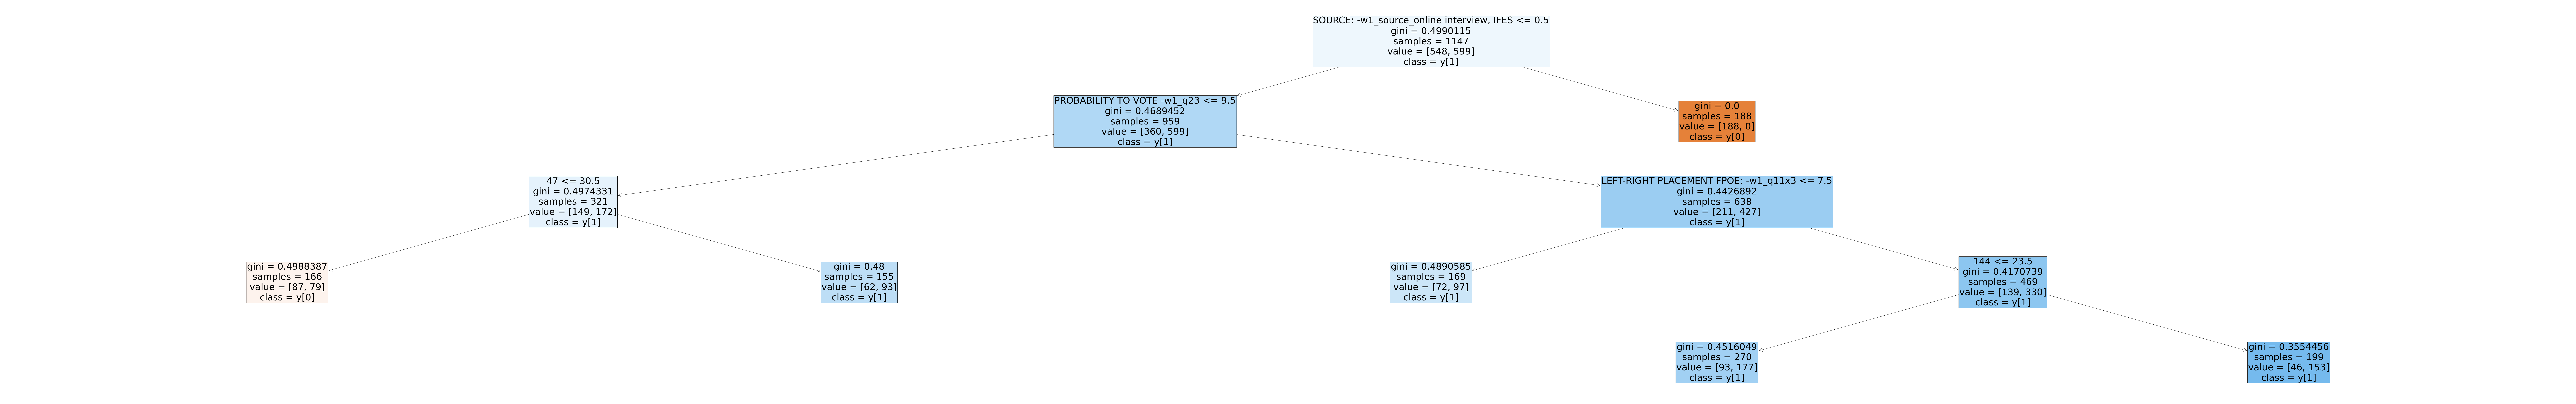

In [76]:
fig = plt.figure(figsize=(250, 40))

_ = tree.plot_tree(clf_fit, filled=True, feature_names=X.feature_names, class_names=True, fontsize=50, precision=7)
plt.show()
#fig.savefig('pol_tree_multi.pdf')

scaling for other models

In [77]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_scaler = scaler.fit(X_train)
X_train = pd.DataFrame(x_scaler.transform(X_train))
X_test = pd.DataFrame(x_scaler.transform(X_test))

## LOGISTIC REGRESSION
default parameters

In [78]:
clf_fit = LogisticRegression(max_iter=10000).fit(X_train, y_train)
y_pred = clf_fit.predict(X_test)
conf = confusion_matrix(y_test, y_pred)
accuracy = clf_fit.score(X_test, y_test)

test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

test_scores(X_test, y_test)
train_scores(X_train, y_train)
add_to_final_table(X_test, y_test)

Precision: 0.636
Recall: 0.747
f1_score: 0.687
Accuracy: 0.645
_____________
Precision_train: 0.79
Recall_train: 0.918
f1_score_train: 0.849
Accuracy_train: 0.830


## SVM 
default parameters

In [79]:
clf = LinearSVC(C=0.01, max_iter=10000)
clf_fit = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
conf = confusion_matrix(y_test, y_pred)

accuracy = clf_fit.score(X_test, y_test)
test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

test_scores(X_test, y_test)
train_scores(X_train, y_train)
add_to_final_table(X_test, y_test)

Precision: 0.662
Recall: 0.873
f1_score: 0.753
Accuracy: 0.700
_____________
Precision_train: 0.723
Recall_train: 0.918
f1_score_train: 0.809
Accuracy_train: 0.773


## RBF SVM 
default parameters

In [80]:
clf = SVC()
clf_fit = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
conf = confusion_matrix(y_test, y_pred)
accuracy = clf_fit.score(X_test, y_test)
test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

test_scores(X_test, y_test)
train_scores(X_train, y_train)
add_to_final_table(X_test, y_test)

Precision: 0.643
Recall: 0.913
f1_score: 0.755
Accuracy: 0.690
_____________
Precision_train: 0.7
Recall_train: 0.98
f1_score_train: 0.817
Accuracy_train: 0.771


<Figure size 720x504 with 0 Axes>

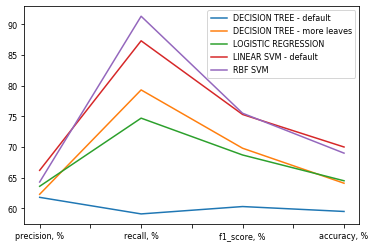

In [81]:
list_of_models = ['DECISION TREE - default',
                  'DECISION TREE - more leaves',
                  'LOGISTIC REGRESSION',
                  'LINEAR SVM - default',
                  'RBF SVM'] 
results_plot = table_of_results(list_of_models, precision_plot, recall_plot, test_f1_score_plot, accuracy_plot)
plot_results(results_plot)

*POLY PERSONAL + POLITICAL*

In [82]:
results_plot

,"precision, %","recall, %","f1_score, %","accuracy, %"
DECISION TREE - default,61.8,59.1,60.3,59.5
DECISION TREE - more leaves,62.3,79.3,69.8,64.1
LOGISTIC REGRESSION,63.6,74.7,68.7,64.5
LINEAR SVM - default,66.2,87.3,75.3,70.0
RBF SVM,64.3,91.3,75.5,69.0


# POLY IMPORTANT FEATURES + OTHERS

In [83]:
df = pd.read_csv('../data/data_multi_personal_online.csv')
y = df['panelpat']
X_personal = df.drop(['panelpat'], axis=1)

In [84]:
X_political = pd.read_csv('../data/data_multi_political_online.csv')
X_political = X_political.filter(regex='(w1)')
#X_political['panelpat']

In [85]:
X = pd.concat([X_personal, X_political], axis=1)

In [86]:
X_important = X[['SOURCE: -w1_source_online interview, IFES',
'SOURCE: -w1_source_online interview, Marketagent',
'CERTAINTY ABOUT PARTICIPATION IN FOLLOW UP SURVEY -w1_sd23',
'SOURCE: -w1_source_online interview, recruted offline',
'Country_of_birth_other',
'w1_occupation_area_farmer',
'religion_Christian-orthodox church',
"UNION MEMBERSHIP -w1_sd17_don't know",
'PARTY R. FEELS CLOSER TO: -w1_q15_KPOE',
'w1_occupation_weiss nicht',
'DEGREE OF CLOSENESS TO PARTY -w1_q16',
'PARTY R. FEELS CLOSER TO: -w1_q15_CPOE',
'ECON. SITUATION AUSTRIA: RETROSPECTIVE (PAST 12 MONTHS) -w1_q3',
'w1_occupation_area_self-employed with employees',
'w1_occupation_military/civilian service, voluntary social year',
'OPINION: PROTECT ENVIRONMENT, EVEN IF LIFE BECOMES MORE EXPENSIVE -w1_q17x4',
'VOTE CHOICE NATIONAL ELECTION 2013: -w1_q9_BZOE',
'Attendance_relig',
'VOTE CHOICE NATIONAL ELECTION 2013: -w1_q9_CPOE',
'PTV: LIST SEBASTIAN KURZ - THE NEW PEOPLES PARTY -w1_q22x2']]


X_others = X.drop(['SOURCE: -w1_source_online interview, IFES',
'SOURCE: -w1_source_online interview, Marketagent',
'CERTAINTY ABOUT PARTICIPATION IN FOLLOW UP SURVEY -w1_sd23',
'SOURCE: -w1_source_online interview, recruted offline',
'Country_of_birth_other',
'w1_occupation_area_farmer',
'religion_Christian-orthodox church',
"UNION MEMBERSHIP -w1_sd17_don't know",
'PARTY R. FEELS CLOSER TO: -w1_q15_KPOE',
'w1_occupation_weiss nicht',
'DEGREE OF CLOSENESS TO PARTY -w1_q16',
'PARTY R. FEELS CLOSER TO: -w1_q15_CPOE',
'ECON. SITUATION AUSTRIA: RETROSPECTIVE (PAST 12 MONTHS) -w1_q3',
'w1_occupation_area_self-employed with employees',
'w1_occupation_military/civilian service, voluntary social year',
'OPINION: PROTECT ENVIRONMENT, EVEN IF LIFE BECOMES MORE EXPENSIVE -w1_q17x4',
'VOTE CHOICE NATIONAL ELECTION 2013: -w1_q9_BZOE',
'Attendance_relig',
'VOTE CHOICE NATIONAL ELECTION 2013: -w1_q9_CPOE',
'PTV: LIST SEBASTIAN KURZ - THE NEW PEOPLES PARTY -w1_q22x2'], axis=1)

In [87]:
X_important_poly = pd.DataFrame(poly.fit_transform(X_important))
X = pd.concat([X_important_poly, X_others], axis=1)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## DECISION TREE
default parameters

In [89]:
kfold = KFold(n_splits=5)
clf = DecisionTreeClassifier(random_state=0)
results = cross_validate(estimator=clf,
                                    X=X_train,
                                    y=y_train,
                                    cv=kfold,
                                    scoring=scoring)
results = pd.DataFrame(results)

In [90]:
precision_plot = []
recall_plot = []
test_f1_score_plot = []
accuracy_plot = []

accuracy_tree = mean(results['test_accuracy'])
precision_tree = mean(results['test_precision'])
recall_tree = mean(results['test_recall'])
test_f1_score_tree = mean(results['test_f1_score'])

precision_plot.append(precision_tree)
recall_plot.append(recall_tree)
test_f1_score_plot.append(test_f1_score_tree)
accuracy_plot.append(accuracy_tree)

accuracy_std = std(results['test_accuracy'])
precision_std = std(results['test_precision'])
recall_std = std(results['test_recall'])
test_f1_score_std = std(results['test_f1_score'])

print('accuracy', round(accuracy_tree, 3))
print('precision', round(precision_tree, 3))
print('recall', round(recall_tree, 3))
print('test_f1_score', round(test_f1_score_tree, 3))
print(' ')
print('accuracy_std', round(accuracy_std, 3))
print('precision_std', round(precision_std, 3))
print('recall_std', round(recall_std, 3))
print('test_f1_score_std', round(test_f1_score_std, 3))

accuracy 0.612
precision 0.632
recall 0.617
test_f1_score 0.623
 
accuracy_std 0.029
precision_std 0.032
recall_std 0.047
test_f1_score_std 0.032


tuning number of leaves

In [91]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), 
                  param_grid={'max_depth': [4], 
                              'min_samples_leaf': min_samples_leaf_list}, 
                  cv=5, scoring=scoring, refit=False)
gs.fit(X_train, y_train)
results = pd.DataFrame(gs.cv_results_)
test_f1_score_tree_train = results['mean_test_f1_score']
precision_tree_train = results['mean_test_precision']
recall_tree_train = results['mean_test_recall']
accuracy_tree_train = results['mean_test_accuracy']

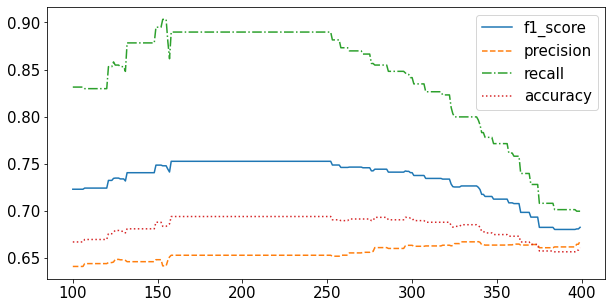

In [92]:
font = {'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
plt.figure(figsize=(10, 5))
plt.plot(min_samples_leaf_list, test_f1_score_tree_train, label="f1_score", linestyle="-")
plt.plot(min_samples_leaf_list, precision_tree_train, label="precision", linestyle="--")
plt.plot(min_samples_leaf_list, recall_tree_train, label="recall", linestyle="-.")
plt.plot(min_samples_leaf_list, accuracy_tree_train, label="accuracy", linestyle=":")
plt.legend()
plt.show()

checking model on test set, min_samples_leaf = 150

In [93]:
clf = DecisionTreeClassifier(min_samples_leaf=150, max_depth=4)
clf_fit = clf.fit(X_train, y_train)
accuracy = clf_fit.score(X_test, y_test)
y_pred = clf_fit.predict(X_test)
conf = confusion_matrix(y_test, y_pred)

test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

test_scores(X_test, y_test)
train_scores(X_train, y_train)
add_to_final_table(X_test, y_test)

Precision: 0.631
Recall: 0.787
f1_score: 0.7
Accuracy: 0.648
_____________
Precision_train: 0.669
Recall_train: 0.84
f1_score_train: 0.745
Accuracy_train: 0.699


In [94]:
# assigning names for columns for plotting decision tree
X.feature_names = X.columns
y.feature_names = ['drop']

scaling for other models

In [95]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_scaler = scaler.fit(X_train)
X_train = pd.DataFrame(x_scaler.transform(X_train))
X_test = pd.DataFrame(x_scaler.transform(X_test))

## LOGISTIC REGRESSION
default parameters

In [96]:
clf_fit = LogisticRegression(max_iter=10000).fit(X_train, y_train)
y_pred = clf_fit.predict(X_test)
conf = confusion_matrix(y_test, y_pred)
accuracy = clf_fit.score(X_test, y_test)

test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

test_scores(X_test, y_test)
train_scores(X_train, y_train)
add_to_final_table(X_test, y_test)

Precision: 0.64
Recall: 0.76
f1_score: 0.695
Accuracy: 0.652
_____________
Precision_train: 0.727
Recall_train: 0.866
f1_score_train: 0.791
Accuracy_train: 0.760


## SVM 
default parameters

In [97]:
clf = LinearSVC(C=0.01, max_iter=10000)
clf_fit = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
conf = confusion_matrix(y_test, y_pred)

accuracy = clf_fit.score(X_test, y_test)
test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

test_scores(X_test, y_test)
train_scores(X_train, y_train)
add_to_final_table(X_test, y_test)

Precision: 0.616
Recall: 0.833
f1_score: 0.708
Accuracy: 0.641
_____________
Precision_train: 0.681
Recall_train: 0.91
f1_score_train: 0.779
Accuracy_train: 0.731


## RBF SVM 
default parameters

In [98]:
clf = SVC()
clf_fit = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
conf = confusion_matrix(y_test, y_pred)
accuracy = clf_fit.score(X_test, y_test)
test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

test_scores(X_test, y_test)
train_scores(X_train, y_train)
add_to_final_table(X_test, y_test)

Precision: 0.63
Recall: 0.967
f1_score: 0.763
Accuracy: 0.686
_____________
Precision_train: 0.671
Recall_train: 0.995
f1_score_train: 0.802
Accuracy_train: 0.743


<Figure size 720x504 with 0 Axes>

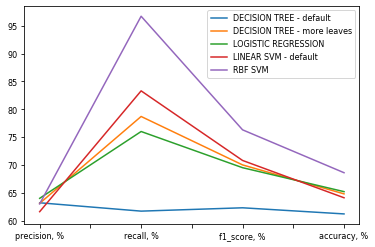

In [99]:
list_of_models = ['DECISION TREE - default',
                  'DECISION TREE - more leaves',
                  'LOGISTIC REGRESSION',
                  'LINEAR SVM - default',
                  'RBF SVM'] 
results_plot = table_of_results(list_of_models, precision_plot, recall_plot, test_f1_score_plot, accuracy_plot)
plot_results(results_plot)

*POLY IMPORTANT FEATURES + OTHERS*

In [100]:
results_plot

,"precision, %","recall, %","f1_score, %","accuracy, %"
DECISION TREE - default,63.2,61.7,62.3,61.2
DECISION TREE - more leaves,63.1,78.7,70.0,64.8
LOGISTIC REGRESSION,64.0,76.0,69.5,65.2
LINEAR SVM - default,61.6,83.3,70.8,64.1
RBF SVM,63.0,96.7,76.3,68.6


# FEATURES INTERACTION (BUNDESLAND AND GENDER)

In [101]:
df = pd.read_csv('../data/data_multi_personal_online.csv')
y = df['panelpat']
X_personal = df.drop(['panelpat'], axis=1)

In [102]:
X_political = pd.read_csv('../data/data_multi_political_online.csv')
X_political = X_political.filter(regex='(w1)')
#X_political = X_political.drop(['panelpat'], axis=1)

In [103]:
X = pd.concat([X_personal, X_political], axis=1)

In [104]:
# https://stackoverflow.com/questions/42969545/interactions-between-dummies-variables-in-python
gender = X.columns[X.columns.str.startswith('GENDER')]
federal_state = X.columns[X.columns.str.startswith('FEDERAL STATE')]

for col1 in gender:
    for col2 in federal_state:
        X[col2 + '_' + col1.split('_')[1]] = X[col1].mul(X[col2])

In [105]:
for i in federal_state:
    X = X.drop(i, axis=1)
for i in gender:
    X = X.drop(i, axis=1)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## DECISION TREE
default parameters

In [107]:
kfold = KFold(n_splits=5)
clf = DecisionTreeClassifier(random_state=0)
results = cross_validate(estimator=clf,
                                    X=X_train,
                                    y=y_train,
                                    cv=kfold,
                                    scoring=scoring)
results = pd.DataFrame(results)

In [108]:
precision_plot = []
recall_plot = []
test_f1_score_plot = []
accuracy_plot = []

accuracy_tree = mean(results['test_accuracy'])
precision_tree = mean(results['test_precision'])
recall_tree = mean(results['test_recall'])
test_f1_score_tree = mean(results['test_f1_score'])

precision_plot.append(precision_tree)
recall_plot.append(recall_tree)
test_f1_score_plot.append(test_f1_score_tree)
accuracy_plot.append(accuracy_tree)

accuracy_std = std(results['test_accuracy'])
precision_std = std(results['test_precision'])
recall_std = std(results['test_recall'])
test_f1_score_std = std(results['test_f1_score'])

print('accuracy', round(accuracy_tree, 3))
print('precision', round(precision_tree, 3))
print('recall', round(recall_tree, 3))
print('test_f1_score', round(test_f1_score_tree, 3))
print(' ')
print('accuracy_std', round(accuracy_std, 3))
print('precision_std', round(precision_std, 3))
print('recall_std', round(recall_std, 3))
print('test_f1_score_std', round(test_f1_score_std, 3))

accuracy 0.617
precision 0.632
recall 0.642
test_f1_score 0.636
 
accuracy_std 0.029
precision_std 0.054
recall_std 0.034
test_f1_score_std 0.036


tuning number of leaves

In [109]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), 
                  param_grid={'max_depth': [4], 
                              'min_samples_leaf': min_samples_leaf_list}, 
                  cv=5, scoring=scoring, refit=False)
gs.fit(X_train, y_train)
results = pd.DataFrame(gs.cv_results_)
test_f1_score_tree_train = results['mean_test_f1_score']
precision_tree_train = results['mean_test_precision']
recall_tree_train = results['mean_test_recall']
accuracy_tree_train = results['mean_test_accuracy']

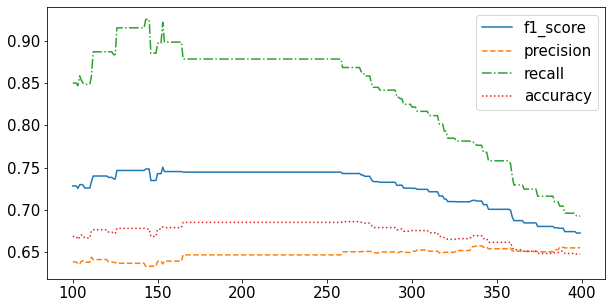

In [110]:
font = {'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
plt.figure(figsize=(10, 5))
plt.plot(min_samples_leaf_list, test_f1_score_tree_train, label="f1_score", linestyle="-")
plt.plot(min_samples_leaf_list, precision_tree_train, label="precision", linestyle="--")
plt.plot(min_samples_leaf_list, recall_tree_train, label="recall", linestyle="-.")
plt.plot(min_samples_leaf_list, accuracy_tree_train, label="accuracy", linestyle=":")
plt.legend()
plt.show()

checking model on test set, min_samples_leaf = 150

In [111]:
clf = DecisionTreeClassifier(min_samples_leaf=150, max_depth=4)
clf_fit = clf.fit(X_train, y_train)
accuracy = clf_fit.score(X_test, y_test)
y_pred = clf_fit.predict(X_test)
conf = confusion_matrix(y_test, y_pred)

test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

test_scores(X_test, y_test)
train_scores(X_train, y_train)
add_to_final_table(X_test, y_test)

Precision: 0.625
Recall: 1.0
f1_score: 0.769
Accuracy: 0.686
_____________
Precision_train: 0.626
Recall_train: 1.0
f1_score_train: 0.77
Accuracy_train: 0.688


In [112]:
# assigning names for columns for plotting decision tree
X.feature_names = X.columns
y.feature_names = ['drop']

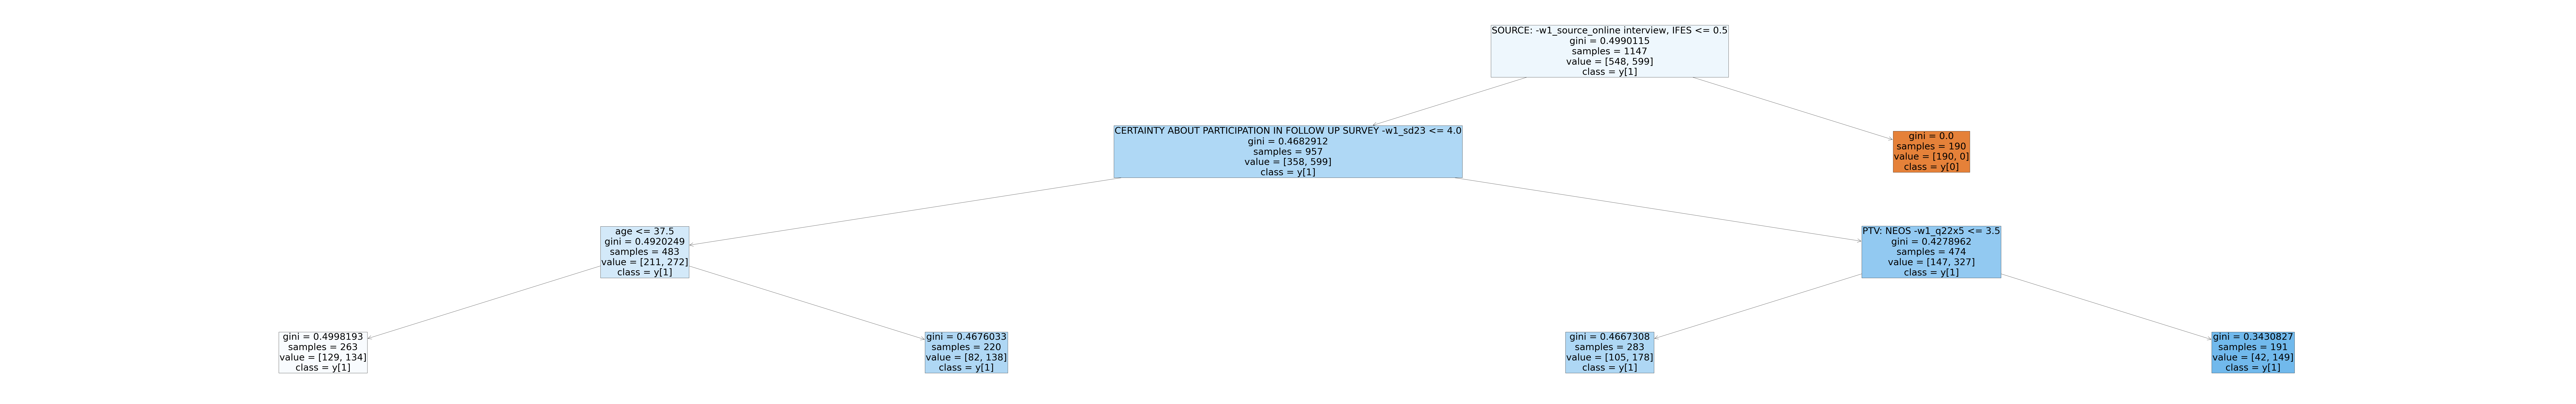

In [113]:
fig = plt.figure(figsize=(250, 40))

_ = tree.plot_tree(clf_fit, filled=True, feature_names=X.feature_names, class_names=True, fontsize=50, precision=7)
plt.show()
#fig.savefig('pol_tree_multi.pdf')

scaling for other models

In [114]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_scaler = scaler.fit(X_train)
X_train = pd.DataFrame(x_scaler.transform(X_train))
X_test = pd.DataFrame(x_scaler.transform(X_test))

## LOGISTIC REGRESSION
default parameters

In [115]:
clf_fit = LogisticRegression(max_iter=10000).fit(X_train, y_train)
y_pred = clf_fit.predict(X_test)
conf = confusion_matrix(y_test, y_pred)
accuracy = clf_fit.score(X_test, y_test)

test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

test_scores(X_test, y_test)
train_scores(X_train, y_train)
add_to_final_table(X_test, y_test)

Precision: 0.64
Recall: 0.807
f1_score: 0.714
Accuracy: 0.662
_____________
Precision_train: 0.712
Recall_train: 0.883
f1_score_train: 0.788
Accuracy_train: 0.752


In [116]:
feature_coef_attention = pd.DataFrame(clf_fit.coef_)
feature_coef_attention.columns = X.columns

## SVM 
default parameters

In [117]:
clf = LinearSVC(C=0.01, max_iter=10000)
clf_fit = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
conf = confusion_matrix(y_test, y_pred)

accuracy = clf_fit.score(X_test, y_test)
test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

test_scores(X_test, y_test)
train_scores(X_train, y_train)
add_to_final_table(X_test, y_test)

Precision: 0.643
Recall: 0.887
f1_score: 0.745
Accuracy: 0.683
_____________
Precision_train: 0.669
Recall_train: 0.915
f1_score_train: 0.773
Accuracy_train: 0.719


## RBF SVM 
default parameters

In [118]:
clf = SVC()
clf_fit = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
conf = confusion_matrix(y_test, y_pred)
accuracy = clf_fit.score(X_test, y_test)
test_f1_score = f1_score(y_test, y_pred)

precision_plot.append(precision_score(y_test, y_pred))
recall_plot.append(recall_score(y_test, y_pred))
test_f1_score_plot.append(test_f1_score)
accuracy_plot.append(accuracy)

test_scores(X_test, y_test)
train_scores(X_train, y_train)
add_to_final_table(X_test, y_test)

Precision: 0.635
Recall: 0.973
f1_score: 0.768
Accuracy: 0.693
_____________
Precision_train: 0.672
Recall_train: 0.993
f1_score_train: 0.801
Accuracy_train: 0.743


<Figure size 720x504 with 0 Axes>

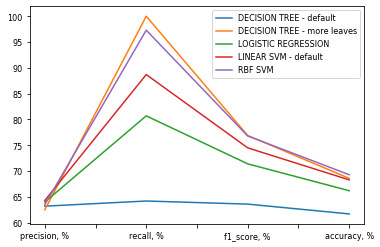

In [119]:
list_of_models = ['DECISION TREE - default',
                  'DECISION TREE - more leaves',
                  'LOGISTIC REGRESSION',
                  'LINEAR SVM - default',
                  'RBF SVM'] 
results_plot = table_of_results(list_of_models, precision_plot, recall_plot, test_f1_score_plot, accuracy_plot)
plot_results(results_plot)

*FEATURES INTERACTION (BUNDESLAND AND GENDER)*

In [120]:
results_plot

,"precision, %","recall, %","f1_score, %","accuracy, %"
DECISION TREE - default,63.2,64.2,63.6,61.7
DECISION TREE - more leaves,62.5,100.0,76.9,68.6
LOGISTIC REGRESSION,64.0,80.7,71.4,66.2
LINEAR SVM - default,64.3,88.7,74.5,68.3
RBF SVM,63.5,97.3,76.8,69.3


# final table of results

In [121]:
add_to_final_table

<function __main__.add_to_final_table(X_test, y_test)>

In [122]:
list_of_all_models = ['X_personal_decision_tree_customized', 
                      'X_personal_Linear_SVM_default', 
                      'X_personal_Linear_SVM_C=0.05', 
                      'X_personal_RBF_SVM', 
                      'X_personal_Logistic_regression', 
                      'X_personal Log regression with poly features', 
                      'All features: decision_tree_customized', 
                      'All features: Logistic_regression', 
                      'All features: Linear SVM', 
                      'All features: RBF SVM', 
                      'Poly personal + political: decision_tree_customized', 
                      'Poly personal + political: Logistic regression', 
                      'Poly personal + political: Linear SVM', 
                      'Poly personal + political: RBF SVM', 
                      'Poly important + others: decision_tree_customized', 
                      'Poly important + others: Logistic regression', 
                      'Poly important + others: Linear SVM', 
                      'Poly important + others: RBF SVM', 
                      'Bundesland + gender features interaction: decision_tree_customized', 
                      'Bundesland + gender features interaction: Logistic_regression', 
                      'Bundesland + gender features interaction: Linear SVM', 
                      'Bundesland + gender features interaction: RBF SVM']

In [123]:
final_results = pd.DataFrame(zip(all_specificity_plot, 
                                 all_precision_plot, 
                                 all_recall_plot, 
                                 all_test_f1_score_plot, 
                                 all_accuracy_plot)).T
final_results.columns = list_of_all_models
final_results.index = ['specificity, %',
                      'precision, %',
                      'recall, %',
                      'f1_score, %',
                      'accuracy, %']
final_results = final_results.round(3)
final_results = final_results.mul(100)

* Specificity - how many samples we find who **drops** the survey (class 0)
* Recall - how many samples we find who **stays** in the next waves (class 1)
* Precision - how many of samples who would **drop** the survey according to prediction do so
* f1_sсore - weighted metric for precision and recall

In [124]:
final_results.T.sort_values(by=['specificity, %'], ascending=False)

,"specificity, %","precision, %","recall, %","f1_score, %","accuracy, %"
Poly personal + political: Logistic regression,53.3,63.6,74.7,68.7,64.5
Poly important + others: Logistic regression,53.3,64.0,76.0,69.5,65.2
All features: decision_tree_customized,52.6,65.4,82.0,72.8,67.9
All features: Logistic_regression,52.6,62.6,72.7,67.3,63.1
Poly personal + political: Linear SVM,51.1,66.2,87.3,75.3,70.0
Bundesland + gender features interaction: Logistic_regression,50.4,64.0,80.7,71.4,66.2
Poly important + others: decision_tree_customized,49.6,63.1,78.7,70.0,64.8
All features: Linear SVM,49.6,64.8,84.7,73.4,67.9
X_personal Log regression with poly features,48.2,59.4,69.3,64.0,59.2
All features: RBF SVM,47.4,65.9,92.7,77.0,71.1


* Since we concentrate on people who drop the survey (e.g. look for the highest specificity), the good trade-off between obtained results on dataset of **Bundesland + gender features interaction: RBF SVM**
* A lot of models demonstrate similar results and might slightly change (1-2%) in terms of metrics due to train_test_split
* Using only personal features does not help to identify respondents who will drop the survey at all, need to ask people anyway
* Decision tree worth to use only to get better insight of important features, results highly depend on train_test_split
* Accuracy 66% is not significant since dataset is unbalanced (1:2)

In [125]:
Counter(df['panelpat'])

Counter({0: 685, 1: 749})

The most important features related to:
* age (-), 
* source, 
* certainty about participation in follow up survey (-), 
* occupation, 
* voting_age_awareness